<a href="https://colab.research.google.com/github/Jeongho-K/Car-model-classification/blob/main/code/2_Car_classification_with_efficient_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car classification

data: https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=554

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 차량 방향 확인할 이미지 리스트 생성

In [ ]:
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import glob

In [ ]:
def make_img_list(BASE_FOLDER, OUTPUT):
    f_list = []
    for model_name in os.listdir(BASE_FOLDER):
        model_path = os.path.join(BASE_FOLDER, model_name)
        for detail_forder in os.listdir(model_path):
            folder_path = os.path.join(model_path, detail_forder + '/*')
            f_list += glob.glob(folder_path)

    with open(OUTPUT, 'w', encoding="UTF8") as f:
        for line in f_list:
            f.write(line)
            f.write('\n')

In [ ]:
train_BASE_FOLDER = r"/content/drive/MyDrive/Car-model-classification/data/1.Training/원천데이터/HY_현대"
train_OUTPUT = '/content/drive/MyDrive/Car-model-classification/data/train_image_list.txt'

make_img_list(train_BASE_FOLDER, train_OUTPUT)

In [ ]:
val_BASE_FOLDER = r"/content/drive/MyDrive/Car-model-classification/data/2.Validation/원천데이터/HY_현대"
val_OUTPUT = '/content/drive/MyDrive/Car-model-classification/data/val_image_list.txt'

make_img_list(val_BASE_FOLDER, val_OUTPUT)

## yolov4 custom(차량 앞, 뒤, 옆 분류)

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15502, done.
remote: Total 15502 (delta 0), reused 0 (delta 0), pack-reused 15502
Receiving objects: 100% (15502/15502), 14.17 MiB | 15.10 MiB/s, done.
Resolving deltas: 100% (10405/10405), done.


- darknet모델내 makefile파일 내용 수정  
- GPU=1, CUDNN=1, OPENCV=1

In [ ]:
import os
path = '/content/darknet'
os.chdir(path)
!make

In [ ]:
# verify installation
!./darknet

usage: ./darknet <function>


In [ ]:
# pretrained weights
import shutil
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/yolov4-car.cfg', 'cfg/yolov4-car.cfg')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/yolov4-car_best.weights', 'cfg/yolov4-car_best.weights')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/car.names', 'data/car.names')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/car.data', 'data/car.data')

'data/car.data'

In [ ]:
!./darknet detector test data/car.data cfg/yolov4-car.cfg cfg/yolov4-car_best.weights -dont_show -out /content/drive/MyDrive/Car-model-classification/data/train_direction_results.json < /content/drive/MyDrive/Car-model-classification/data/train_image_list.txt

In [ ]:
!./darknet detector test data/car.data cfg/yolov4-car.cfg cfg/yolov4-car_best.weights -dont_show -out /content/drive/MyDrive/Car-model-classification/data/val_direction_results.json < /content/drive/MyDrive/Car-model-classification/data/val_image_list.txt

### 차량 front, side, back label
yolo모델로 생성된 direction_results.json으로 방향 class별 3개 라벨 데이터 생성

## 이미지 crop

In [ ]:
import os
import json
import cv2
import numpy as np
import shutil

In [ ]:
# 텍스트 읽기
def read_text(file_path, encoding="utf-8"):
    text = None
    with open(file_path, 'r', encoding=encoding) as f:
        text = f.read()
    return text

In [ ]:
def load_json(json_path, encoding="utf-8"):
    return json.loads(read_text(json_path, encoding))

In [ ]:
def check_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [ ]:
# box 정보에 대해 margin 값만큼 확장함
def expand_box(box, margin, img_width = None, img_height = None):
    x = box["left"]
    y = box["top"]
    w = box["width"]
    h = box["height"]

    x = x - margin
    x = max(x, 0)
    y = y - margin
    y = max(y, 0)

    w = w + 2*margin
    if img_width and x + w > img_width:
        w = img_width - x
    
    h = h + 2*margin
    if img_height and y + h > img_height:
        h = img_height - y

    new_box = {
        "left": x, 
        "top": y,
        "width": w,
        "height": h
    }

    return new_box

In [ ]:
# 이미지 crop
def crop_image(image_np, box, margin = 0):
    if margin > 0:
        box = expand_box(box, margin)
       
    x1 = box["left"]
    y1 = box["top"]
    x2 = box["left"] + box["width"]
    y2 = box["top"] + box["height"]
    return image_np[y1:y2, x1:x2]

In [ ]:
# 한글 경로 지원
def imread( file_path ) :
    stream = open( file_path.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    np_array = np.asarray(bytes, dtype=np.uint8)
    return cv2.imdecode(np_array , cv2.IMREAD_UNCHANGED)

In [ ]:
# 한글 경로 지원
def imwrite(file_path, img, params=None):
    try: 
        ext = os.path.splitext(file_path)[1]
        result, n = cv2.imencode(ext, img, params)
        if result: 
            with open(file_path, mode='w+b') as f:
                n.tofile(f)
                return True
        else: 
            return False 
    except Exception as e: 
        print(e)
        return False

In [ ]:
# 전체 이미지 bbox가 있는 경우 crop해서 방향정보에 따라 저장 
def crop_store_by_direction(direction_path, BASE_OUTPUT_FOLDER):
    dir_json = load_json(direction_path)

    for dir in dir_json:

        if len(dir['objects']) > 0:
            confidence = [x['confidence'] for x in dir['objects']]
            best_idx = confidence.index(max(confidence)) # 가장 신뢰도 높은 분류 class

            img_path = dir['filename']
            tmp_list = img_path.split('/')
            tmp_list[7] = '라벨링데이터'
            img_name = tmp_list[11]
            json_name = img_name.split('.')[0] + '.json'
            json_path = '/'.join(tmp_list[:-1]) + '/' + json_name

            img_json = load_json(json_path)
            object_list = img_json["learningDataInfo"]["objects"]
            
            

            for i in range(len(object_list)):
                if img_json["learningDataInfo"]["objects"][i]["classId"] == 'P00.차량전체':
                    # 차량 전체 bbox
                    box = {
                            "left": int(img_json["learningDataInfo"]["objects"][i]["left"]),
                            "top": int(img_json["learningDataInfo"]["objects"][i]["top"]),
                            "width": int(img_json["learningDataInfo"]["objects"][i]["width"]),
                            "height": int(img_json["learningDataInfo"]["objects"][i]["height"])
                            }

                    # 이미지 크롭
                    img = imread(img_path)
                    cropped_img = crop_image(img, box, 10)

                    # 방향 확인 후 해당 폴더에 저장
                    direction = dir['objects'][best_idx]['name']
                    output_folder = os.path.join(BASE_OUTPUT_FOLDER, direction)
                    check_folder(output_folder)
                    output_path = os.path.join(output_folder, str(img_name))

                    imwrite(output_path, cropped_img)

                    # 라벨링 데이터도 같이 이동
                    shutil.copyfile(json_path, os.path.join(output_folder, str(json_name)))

        print(dir['frame_id'])

In [ ]:
# train & validation img
train_val_direction_path = '/content/drive/MyDrive/Car-model-classification/data/train_direction_results.json'
train_val_output_folder = '/content/drive/MyDrive/Car-model-classification/data/cropimg/train_val'

crop_store_by_direction(train_val_direction_path, train_val_output_folder)

In [ ]:
# test img
val_direction_path = '/content/drive/MyDrive/Car-model-classification/data/val_direction_results.json'
val_output_folder = '/content/drive/MyDrive/Car-model-classification/data/cropimg/test'

crop_store_by_direction(val_direction_path, val_output_folder)

## Imports

In [9]:
pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import efficientnet.keras as efn
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop

## Hyper parameters

In [11]:
batch_size = 48

width = 300
height = 300
epochs = 20
dropout_rate = 0.2
input_shape = (height, width, 3)

## image dastaframe

In [12]:
import pandas as pd
import json
import os

In [13]:
# 텍스트 읽기
def read_text(file_path, encoding="utf-8"):
    text = None
    with open(file_path, 'r', encoding=encoding) as f:
        text = f.read()
    return text

In [14]:
def load_json(json_path, encoding="utf-8"):
    return json.loads(read_text(json_path, encoding))

### setup image dataframe

In [15]:
def make_df(dataset_path, direction):
    base_path = os.path.join(dataset_path, direction)
    img_path = []
    brand = []
    model = []
    for files in os.listdir(base_path):
        if os.path.splitext(files)[1] == '.json':
            tmp_json = load_json(os.path.join(base_path, files))
            img_path.append(os.path.join(base_path, tmp_json['sourceDataInfo']['sourceDataID']+'.jpg'))
            brand.append(tmp_json['rawDataInfo']['MediumCategoryId'])
            model.append(tmp_json['rawDataInfo']['SmallCategoryId'])

    data = {
        'img_path':img_path,
        'brand':brand,
        'model':model
    }
    df = pd.DataFrame(data)
    return df

In [16]:
base_dir = '/content/drive/MyDrive/Car-model-classification/data/cropimg'
train_val_dir = os.path.join(base_dir, 'train_val')
test_dir = os.path.join(base_dir, 'test')

In [17]:
# Setup the front Image df
train_val_front_df = make_df(train_val_dir, 'car_front')
test_front_df = make_df(test_dir, 'car_front')

# Setup the side Image df
train_val_side_df = make_df(train_val_dir, 'car_side')
test_side_df = make_df(test_dir, 'car_side')

# Setup the back Image df
train_val_back_df = make_df(train_val_dir, 'car_back')
test_back_df = make_df(test_dir, 'car_back')

### split train, validation dataframe

In [18]:
# 각 차량 모델별 20%를 추출해 val_df로
def split_df(train_val_df):
    val_df = pd.DataFrame()
    for model in list(train_val_df['model'].unique()):
        sample_df = train_val_df[train_val_df['model'] == model].sample(frac=0.2)
        val_df = pd.concat([val_df, sample_df], ignore_index=True)

    train_df = pd.concat([train_val_df, val_df, val_df]).drop_duplicates(keep=False).reset_index()
    return train_df, val_df

In [19]:
# split train, val
train_front_df, val_front_df = split_df(train_val_front_df)
train_side_df, val_side_df = split_df(train_val_side_df)
train_back_df, val_back_df = split_df(train_val_back_df)

In [20]:
print(len(train_front_df))
print(len(val_front_df))
print(len(test_front_df))
print()

print(len(train_side_df))
print(len(val_side_df))
print(len(test_side_df))
print()

print(len(train_back_df))
print(len(val_back_df))
print(len(test_back_df))

5830
1459
877

5336
1335
887

5116
1277
835


## image dataset

ImageDataGenerator  
* rotation_range : 이미지회전값  
* zoom_range : 이미지일부확대  
* shear_range : 이미지기울기  
* width_shift_range : 좌우이동  
* height_shift_range : 상하이동  
* horizontal_flip : 이미지가로뒤집기  
* vertical_filp : 이미지세로뒤집기

In [21]:
def generate_dataset(train_df, val_df, test_df):
    train_generator = ImageDataGenerator(rescale = 1./300.,
                                    rotation_range = 45,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)

    test_generator = ImageDataGenerator(rescale = 1./300.)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='img_path',
        y_col='model',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='img_path',
        y_col='model',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='img_path',
        y_col='model',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    return train_images, val_images, test_images

In [22]:
train_front_images, val_front_images, test_front_images = generate_dataset(train_front_df, val_front_df, test_front_df)
train_side_images, val_side_images, test_side_images = generate_dataset(train_side_df, val_side_df, test_side_df)
train_back_images, val_back_images, test_back_images = generate_dataset(train_back_df, val_back_df, test_back_df)

Found 5830 validated image filenames belonging to 16 classes.
Found 1459 validated image filenames belonging to 16 classes.
Found 877 validated image filenames belonging to 16 classes.
Found 5336 validated image filenames belonging to 16 classes.
Found 1335 validated image filenames belonging to 16 classes.
Found 887 validated image filenames belonging to 16 classes.
Found 5116 validated image filenames belonging to 16 classes.
Found 1277 validated image filenames belonging to 16 classes.
Found 835 validated image filenames belonging to 16 classes.


# Front car images

## load the conv base model(efficientNetB3)

In [36]:
base_model = efn.EfficientNetB3(input_shape = (224, 224, 3),
                                include_top = False, weights = 'imagenet')

In [37]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalMaxPooling2D(name="gap")) # 최대값을 뽑아내서 overfitting 회피
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out")) # 비율로 연결을 끊어 overfitting 회피
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(16, activation='softmax', name="fc_out")) # 결과

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 7, 7, 1536)       10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 16)                24592     
                                                                 
Total params: 10,808,120
Trainable params: 10,720,824
Non-trainable params: 87,296
_________________________________________________________________


In [39]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

base_model.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 340
This is the number of trainable layers after freezing the conv base: 2


In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_front_images,
      epochs=epochs,
      validation_data=val_front_images,
      verbose=1,
      use_multiprocessing=True)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-40-209ce762744d>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
122/122 [==============================] - 259s 2s/step - loss: 9.1425 - acc: 0.0695 - val_loss: 5.3525 - val_acc: 0.1062
Epoch 2/20
122/122 [==============================] - 247s 2s/step - loss: 7.6080 - acc: 0.0928 - val_loss: 4.9167 - val_acc: 0.1062
Epoch 3/20
122/122 [==============================] - 248s 2s/step - loss: 7.1939 - acc: 0.0997 - val_loss: 4.4997 - val_acc: 0.1302
Epoch 4/20
122/122 [==============================] - 247s 2s/step - loss: 6.9417 - acc: 0.1053 - val_loss: 4.1883 - val_acc: 0.1357
Epoch 5/20
122/122 [==============================] - 249s 2s/step - loss: 6.5416 - acc: 0.1218 - val_loss: 4.0022 - val_acc: 0.1419
Epoch 6/20
122/122 [==============================] - 241s 2s/step - loss: 6.4197 - acc: 0.1221 - val_loss: 3.7844 - val_acc: 0.1666
Epoch 7/20
122/122 [==============================] - 245s 2s/step - loss: 6.2095 - acc: 0.1312 - val_loss: 3.7792 - val_acc: 0.1734
Epoch 8/20
122/122 [==============================] - 237s 2s/step - 

### Results

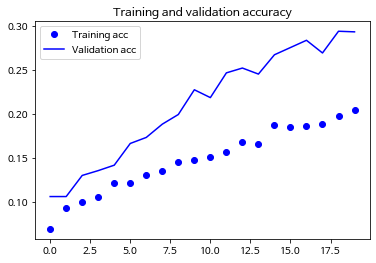

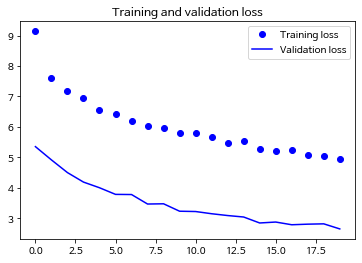

In [41]:
# 학습 결과
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
# test image set 결과
results = model.evaluate(test_front_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 27.37%


### Heatmap
실제 label과 해당 사진을 모델이 예측한 결과

In [ ]:
# 한글폰트 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [44]:
# 한글폰트 지정
plt.rc('font', family='NanumBarunGothic')

In [45]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
predictions = np.argmax(model.predict(test_front_images), axis=1)

cm = confusion_matrix(test_front_images.labels, predictions)

19/19 [==============================] - 10s 399ms/step


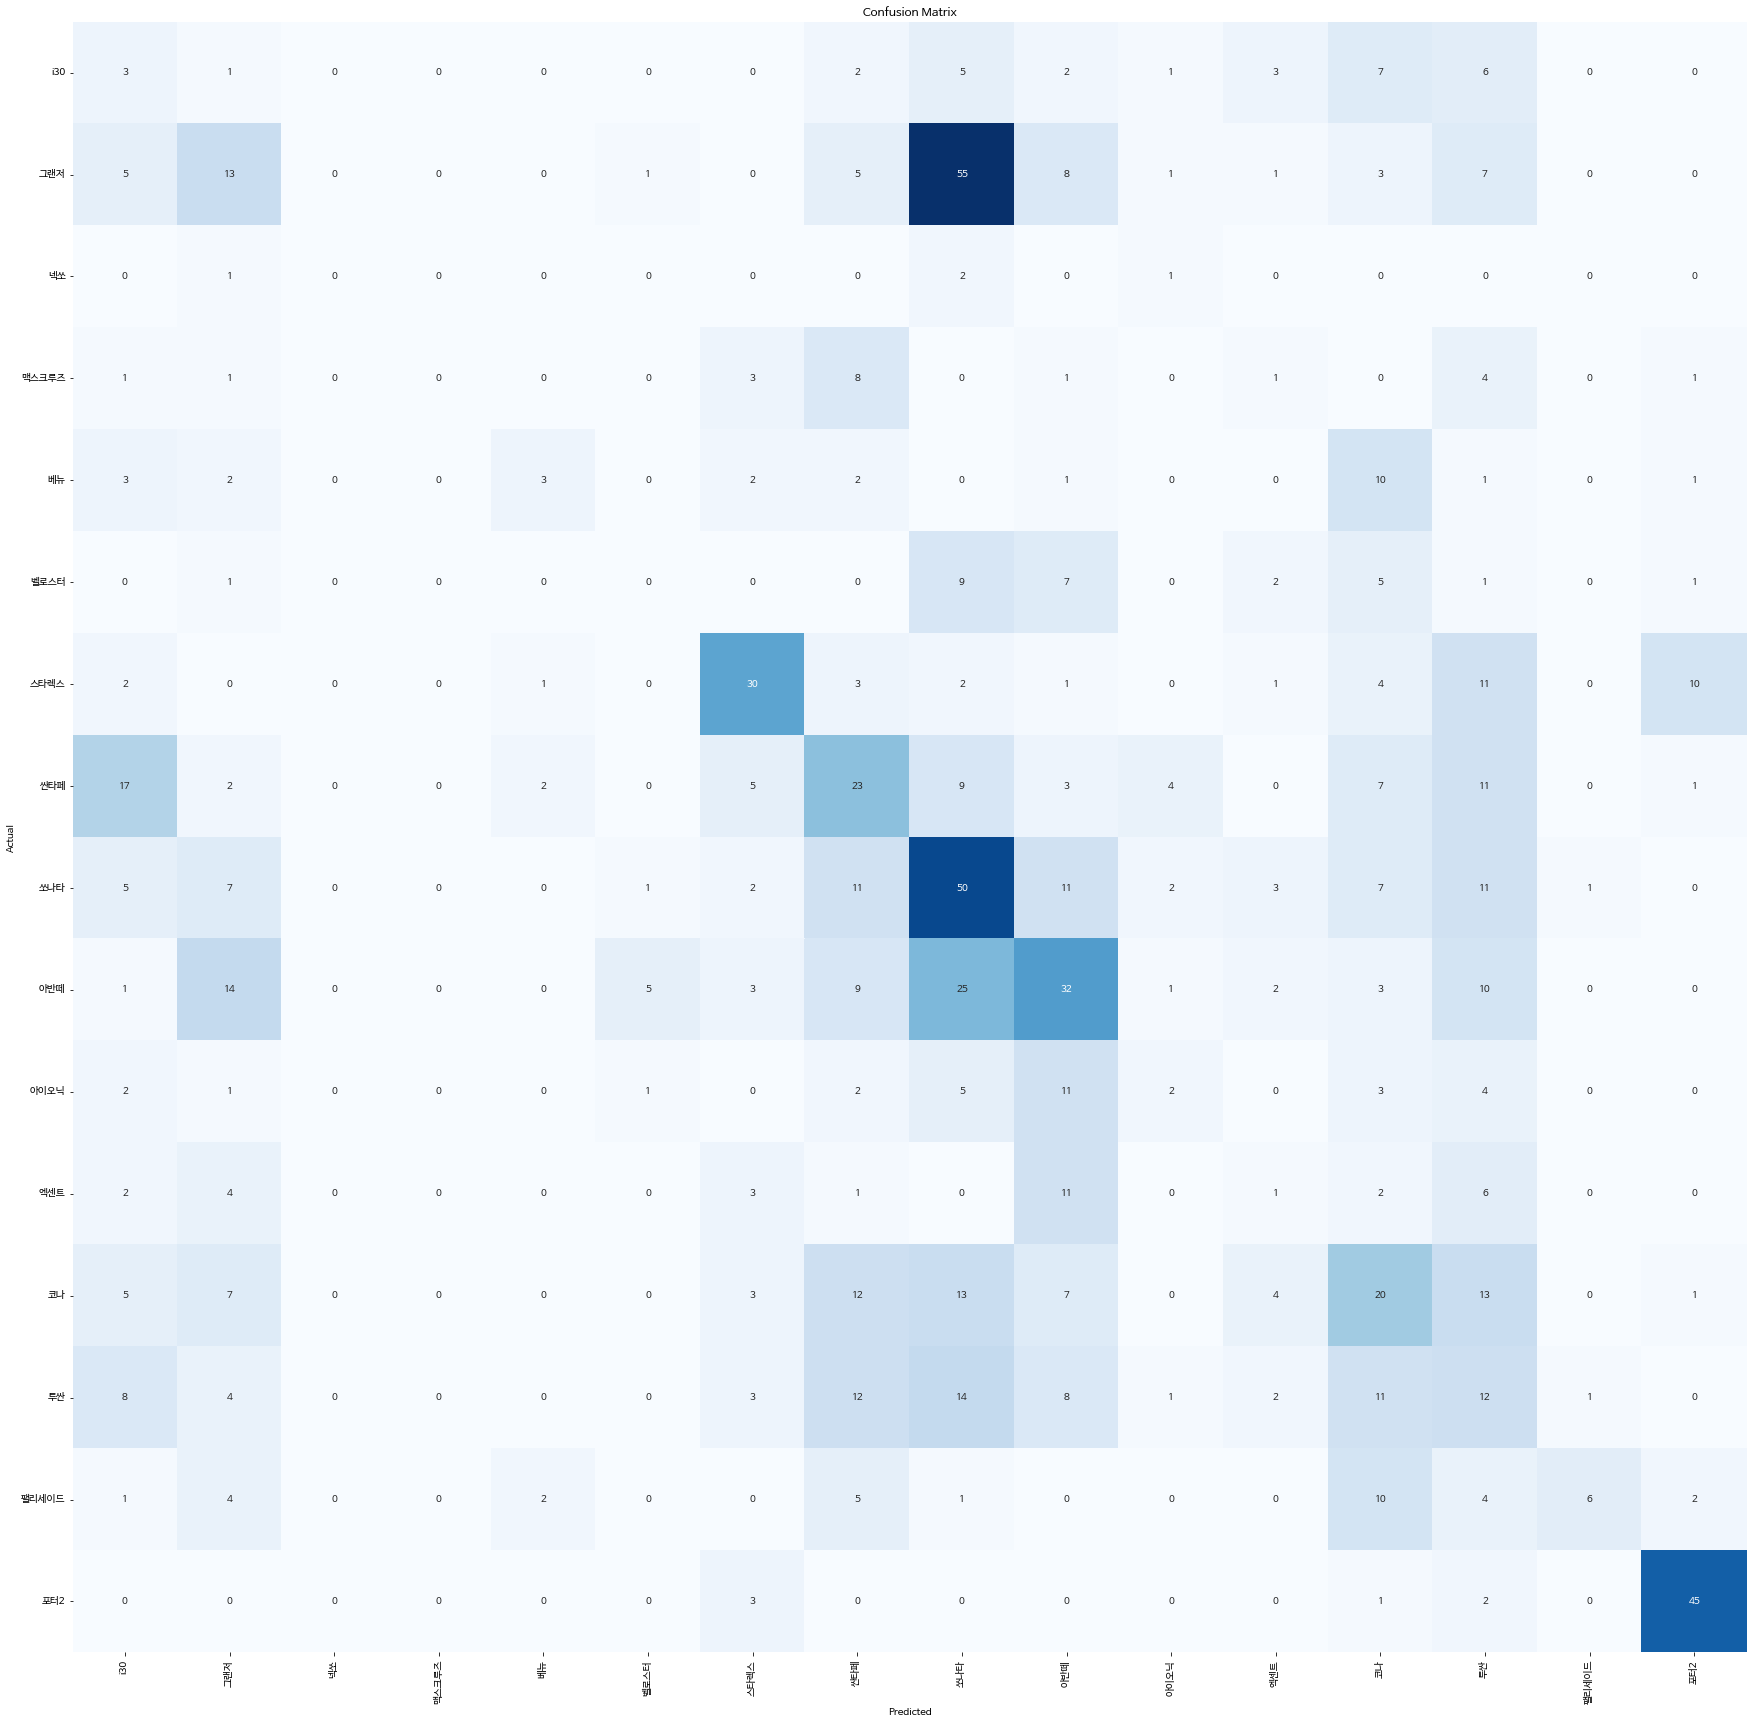

In [47]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(16) + 0.5, labels=test_front_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(16) + 0.5, labels=test_front_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Fine tuning last several layers.

In [26]:
# multiply_16
# set 'multiply_16' and following layers trainable
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_front_images,
      epochs=epochs,
      validation_data=val_front_images,
      verbose=1,
      use_multiprocessing=True)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-27-209ce762744d>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
122/122 [==============================] - 267s 2s/step - loss: 8.3439 - acc: 0.0911 - val_loss: 5.3109 - val_acc: 0.1042
Epoch 2/20
122/122 [==============================] - 249s 2s/step - loss: 7.5892 - acc: 0.0938 - val_loss: 4.8557 - val_acc: 0.0987
Epoch 3/20
122/122 [==============================] - 249s 2s/step - loss: 7.2322 - acc: 0.1098 - val_loss: 4.5692 - val_acc: 0.1206
Epoch 4/20
122/122 [==============================] - 250s 2s/step - loss: 6.9488 - acc: 0.1091 - val_loss: 4.1799 - val_acc: 0.1391
Epoch 5/20
122/122 [==============================] - 249s 2s/step - loss: 6.6952 - acc: 0.1139 - val_loss: 4.0148 - val_acc: 0.1364
Epoch 6/20
122/122 [==============================] - 250s 2s/step - loss: 6.6377 - acc: 0.1249 - val_loss: 3.9212 - val_acc: 0.1556
Epoch 7/20
122/122 [==============================] - 247s 2s/step - loss: 6.2493 - acc: 0.1350 - val_loss: 3.7091 - val_acc: 0.1885
Epoch 8/20
122/122 [==============================] - 250s 2s/step - 

In [28]:
# save model
model.save('/content/drive/MyDrive/Car-model-classification/models/car_model1.h5')

### Results

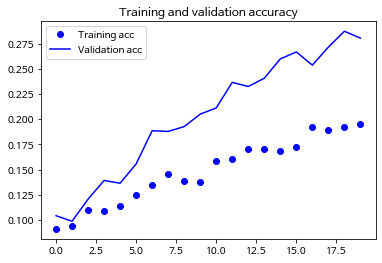

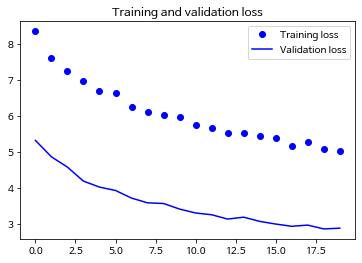

In [29]:
# 학습 결과
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
# test image set 결과
results = model.evaluate(test_front_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 29.30%


### Heatmap
실제 label과 해당 사진을 모델이 예측한 결과

In [31]:
# 한글폰트 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [32]:
# 한글폰트 지정
plt.rc('font', family='NanumBarunGothic')

In [33]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
predictions = np.argmax(model.predict(test_front_images), axis=1)

cm = confusion_matrix(test_front_images.labels, predictions)

19/19 [==============================] - 11s 424ms/step


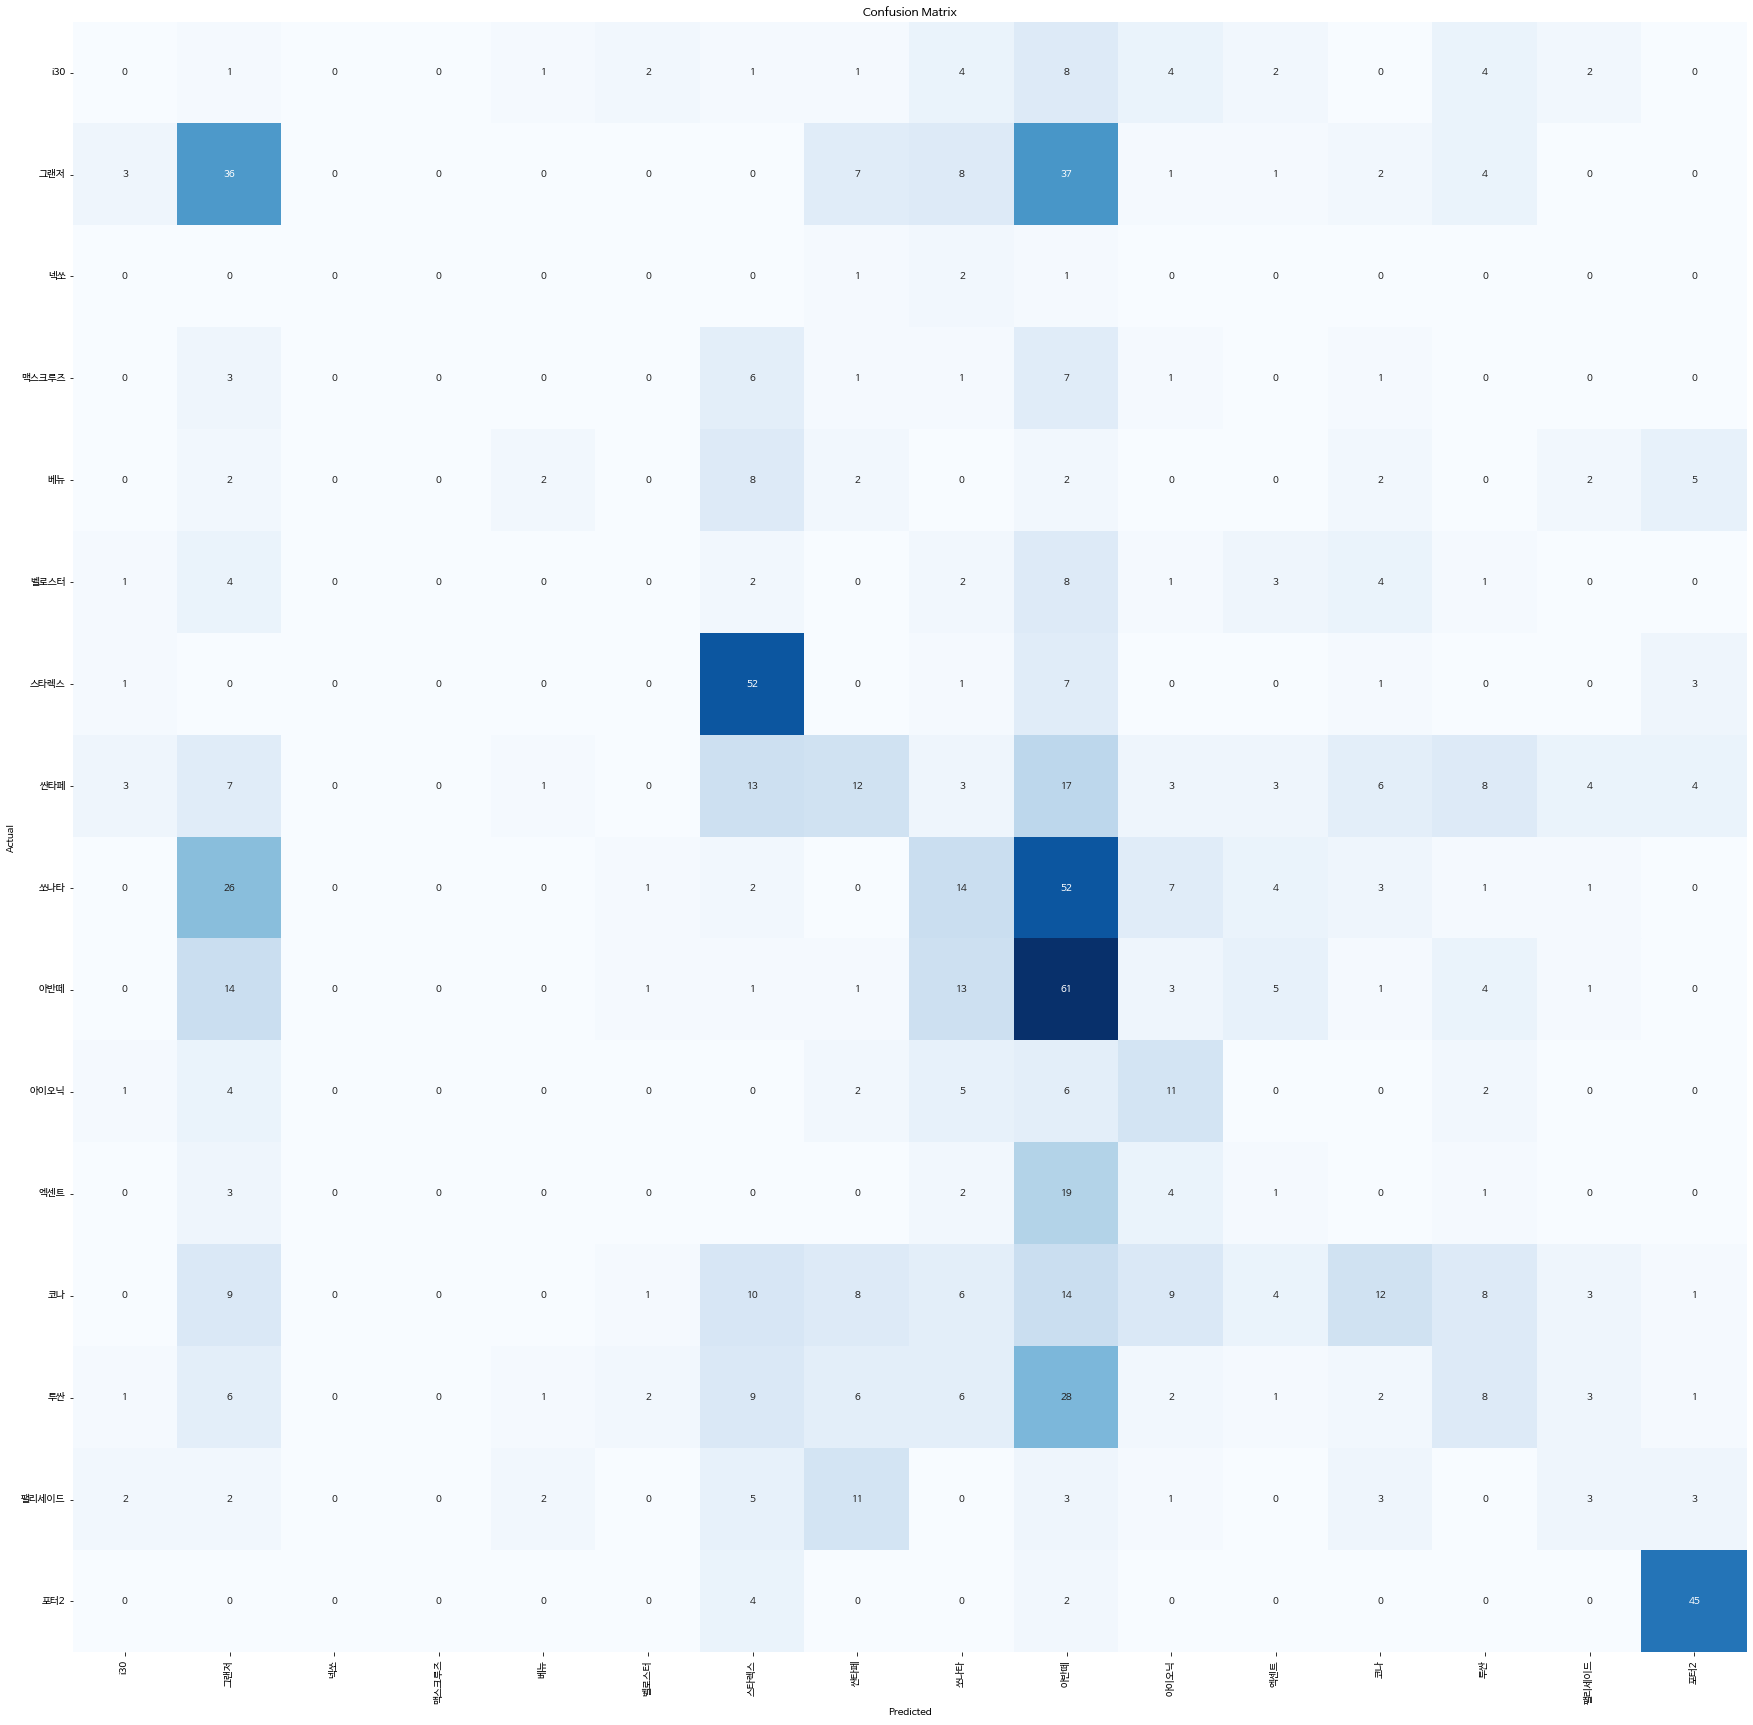

In [35]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(16) + 0.5, labels=test_front_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(16) + 0.5, labels=test_front_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()